Arrange the sales of each store per category for Dunnhumby

Store cluster missing!

Save all the store sales per category in a pickle file so we can easily delve into store level when needed.

Updates:

01.02.2021 - Adapt the script to Dunnhumby data.

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fcn_helpers as fhelp
import fcn_simulation as fsim
fhelp.makeFolder('results')
pd.options.display.max_rows = None
# Use v2.0 colour cycle
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Fig sizes
fig_h = 10
fig_w = 18

In [2]:
outputBaseFolder = '~/Google Drive/order/Machine Learning Part/data/Dunnhumby'

### Prepare the Dunnhumby data here in a similar format than Walmart

In [3]:
cf_dataFolder = '/Users/carlos.aguilar/Documents/Kaggle/dunnhumby_Breakfast-at-the-Frat/data'
# Read the stores
pickleFile = 'store_data.pickle'
picklePath = os.path.join(cf_dataFolder, pickleFile)
df_stores = pd.read_pickle(picklePath)

cols_to_rename = {'ADDRESS_STATE_PROV_CODE':'state_id',
                 'STORE_ID' :'store_nbr',
                 'ADDRESS_CITY_NAME' :'city',
                  'SEG_VALUE_NAME': 'type'
                 }

df_stores.rename(columns=cols_to_rename, inplace=True)
df_stores.drop_duplicates(subset=['store_nbr'], keep='first', inplace=True)

df_stores['cluster'] = 1
df_stores['store_id'] = df_stores[['state_id', 'store_nbr', 'type', 'cluster']].apply(lambda st: f'{st[0]}_{st[1]}_{st[2]}_{st[3]}', axis=1)
df_stores['store_id'] = df_stores['store_id'].apply(lambda string: string.replace(' ', '_'))
mapper_store_id = dict(zip(df_stores['store_nbr'],df_stores['store_id']))

foldername = os.path.join(os.path.expanduser(outputBaseFolder), 'store_info')
fhelp.makeFolder(foldername)
filename = os.path.join(foldername, 'stores.pickle')
fhelp.toPickleFile(df_stores, filename)

#fhelp.to_random_excel_file(df_stores)

df_stores.tail(3)

Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/store_info/stores.pickle


,store_nbr,STORE_NAME,city,state_id,MSA_CODE,type,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS,cluster,store_id
76,23067,WHIPP & BIGGER,KETTERING,OH,19380,MAINSTREAM,230.0,37319,14555.935897,1,OH_23067_MAINSTREAM_1
77,27175,KATY,KATY,TX,26420,UPSCALE,NaN,50224,24901.948718,1,TX_27175_UPSCALE_1
78,28909,MIDDLETOWN,MIDDLETOWN,OH,17140,MAINSTREAM,NaN,85876,28986.108974,1,OH_28909_MAINSTREAM_1


In [7]:
pickleFile = 'products_data.pickle'
picklePath = os.path.join(cf_dataFolder, pickleFile)
df_items = pd.read_pickle(picklePath)
print(df_items.UPC.nunique())
df_items.head(2)

58


,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ


In [5]:
# Read the items
pickleFile = 'products_data.pickle'
picklePath = os.path.join(cf_dataFolder, pickleFile)
df_items = pd.read_pickle(picklePath)

df_items['family'] = df_items['CATEGORY']

mapper_family_to_category = dict(zip(df_items['SUB_CATEGORY'].tolist(), df_items['CATEGORY'].tolist()))

cols_to_rename = {'UPC': 'item_id',
                 'CATEGORY' :'cat_id',
                 'SUB_CATEGORY' :'dept_id'}
df_items.rename(columns=cols_to_rename, inplace=True)

fcn_fix_names = lambda str: str.replace(' ', '.').replace('/','.')

#mapper_to_dept_id = dict(zip(families, dept_ids))
df_items['dept_id'] = df_items['dept_id'].apply(lambda s: fcn_fix_names(s))
df_items['cat_id'] = df_items['cat_id'].apply(lambda s: fcn_fix_names(s))

mapper_dept_to_category = dict(zip(df_items['dept_id'], df_items['cat_id']))

df_items.sort_values(by=['cat_id', 'dept_id'], ascending=True, inplace=True)
#fhelp.to_random_excel_file(df_items)

# Save to a file
foldername = os.path.join(os.path.expanduser(outputBaseFolder), 'sku_hierarchy')
fhelp.makeFolder(foldername)
filename = os.path.join(foldername, 'items.pickle')
fhelp.toPickleFile(df_items, filename)

df_items.head(2)

Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/sku_hierarchy/items.pickle


,item_id,DESCRIPTION,MANUFACTURER,cat_id,dept_id,PRODUCT_SIZE,family
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG.SNACKS,PRETZELS,15 OZ,BAG SNACKS
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG.SNACKS,PRETZELS,15 OZ,BAG SNACKS


### Read the transactions

In [6]:
pickleFile = 'transaction_data.pickle'
picklePath = os.path.join(cf_dataFolder, pickleFile)
df_transaction = pd.read_pickle(picklePath)

cols_to_rename = {'UPC': 'item_id',
                 'UNITS': 'sales',
                 'STORE_NUM' :'store_nbr',
                  'TPR_ONLY': 'onpromotion',
                  'WEEK_END_DATE': 'date'
                 }

df_transaction.rename(columns=cols_to_rename, inplace=True)
df_transaction['discount'] = df_transaction['BASE_PRICE']-df_transaction['PRICE']
df_transaction.onpromotion = df_transaction.onpromotion.astype(bool)
df_transaction.head(2)

,date,store_nbr,item_id,sales,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,onpromotion,discount
0,2009-01-14,367,1111009477,13,13,13,18.07,1.39,1.57,0,0,True,0.18
1,2009-01-14,367,1111009497,20,18,18,27.80,1.39,1.39,0,0,False,0.00


In [7]:
# save the items
foldername = os.path.join(os.path.expanduser(outputBaseFolder), 'item_sales')
fhelp.makeFolder(foldername)

for iSKU in df_transaction.item_id.unique():
    idx_SKU = df_transaction.item_id == iSKU
    filename = os.path.join(foldername, f'{iSKU}.pickle')
    fhelp.toPickleFile(df_transaction[idx_SKU], filename)

Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/item_sales/1111009477.pickle
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/item_sales/1111009497.pickle
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/item_sales/1111009507.pickle
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/item_sales/1111035398.pickle
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/item_sales/1111038078.pickle
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/item_sales/1111038080.pickle
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/item_sales/1111085319.pickle
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/item_

## Iterate through all the departments and stores

In [8]:
#dept_id = 'BREAD_BAKERY' # comes from dept_ids
all_dept_id = df_items['dept_id'].unique().tolist()#[0:1]
#all_dept_id.remove('GROCERY_I')

idx_dates = pd.date_range(df_transaction.date.min(), df_transaction.date.max(), freq='7D')

for dept_id in all_dept_id:
    
    # Find the sales for the current dept_id
    idx_dept_id = df_items.dept_id==dept_id
    list_skus = df_items[idx_dept_id].item_id.unique().tolist()
    df_sales_dept_id = df_transaction[df_transaction.item_id.isin(list_skus)].copy()

    cat_id = mapper_dept_to_category[dept_id]
    
    list_store_id = df_sales_dept_id.store_nbr.unique().tolist()
    total_stores = len(list_store_id)

    for idx_this_store, current_store_id in enumerate(list_store_id):

        print(f'{idx_this_store}/{total_stores}-Working on {current_store_id}...')

        df_sales_dept_id_store_id = df_sales_dept_id[df_sales_dept_id.store_nbr==current_store_id]
        total_units = np.zeros(shape=idx_dates.shape[0])
        df_store_sales = pd.DataFrame({'date':idx_dates, 'weekdays':idx_dates.day_name()})

        store_name = mapper_store_id[current_store_id]
        num_skus = len(list_skus)

        for current_sku in list_skus:
            df_micro_level = df_sales_dept_id_store_id[df_sales_dept_id_store_id.item_id == current_sku].copy()

            # Create a DF as a placeholder and fill it with data
            df_temp = pd.DataFrame({'date': idx_dates, 'store_nbr': current_store_id, 'item_id': current_sku})
            # let's do a left join
            df_merged = pd.merge(df_temp, df_micro_level, how='left', on=['date', 'store_nbr', 'item_id'],copy=True)
            df_merged.sales.fillna(0.0, inplace=True)
            df_merged.onpromotion.fillna(False, inplace=True)
            df_merged.sort_values(by=['date'], ascending=True)

            # update the main DF
            sales_var = f'sales-{dept_id}_{current_sku}-{store_name}'
            promo_var = f'promotion_flag-{dept_id}_{current_sku}-{store_name}'
            df_store_sales[sales_var] = df_merged['sales']
            df_store_sales[promo_var] = df_merged['onpromotion']
            total_units += df_merged['sales']

        # update the total sales
        df_store_sales['total_units']=total_units

        # save the info
        foldername = os.path.join(os.path.expanduser(outputBaseFolder), cat_id, dept_id, 'store_sales')
        fhelp.makeFolder(foldername)
        filename = os.path.join(foldername, f'{store_name}.pickle')

        fhelp.toPickleFile(df_store_sales, filename)

0/77-Working on 367...
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/BAG.SNACKS/PRETZELS/store_sales/KY_367_VALUE_1.pickle
1/77-Working on 387...
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/BAG.SNACKS/PRETZELS/store_sales/OH_387_UPSCALE_1.pickle
2/77-Working on 389...
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/BAG.SNACKS/PRETZELS/store_sales/KY_389_MAINSTREAM_1.pickle
3/77-Working on 613...
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/BAG.SNACKS/PRETZELS/store_sales/TX_613_MAINSTREAM_1.pickle
4/77-Working on 623...
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/BAG.SNACKS/PRETZELS/store_sales/TX_623_MAINSTREAM_1.pickle
5/77-Working on 2277...
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning 

### Let's come up with the store sales per dept_id

In [9]:
dept_id = 'PRETZELS' # comes from dept_ids
#idx_dates = pd.date_range('2017-01-01', '2017-08-15')
cat_id = mapper_dept_to_category[dept_id]
cat_id

'BAG.SNACKS'

In [10]:
# Find the sales for the current dept_id
idx_dept_id = df_items.dept_id==dept_id
list_skus = df_items[idx_dept_id].item_id.unique().tolist()

df_sales_dept_id = df_transaction[df_transaction.item_id.isin(list_skus)].copy()
df_sales_dept_id.head(2)

,date,store_nbr,item_id,sales,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,onpromotion,discount
0,2009-01-14,367,1111009477,13,13,13,18.07,1.39,1.57,0,0,True,0.18
1,2009-01-14,367,1111009497,20,18,18,27.80,1.39,1.39,0,0,False,0.00


In [11]:
list_store_id = df_sales_dept_id.store_nbr.unique().tolist()
# I'll loop through the stores
current_store_id = list_store_id[0]
current_store_id = 367
df_sales_dept_id_store_id = df_sales_dept_id[df_sales_dept_id.store_nbr==current_store_id]
df_sales_dept_id_store_id.head(2)

,date,store_nbr,item_id,sales,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,onpromotion,discount
0,2009-01-14,367,1111009477,13,13,13,18.07,1.39,1.57,0,0,True,0.18
1,2009-01-14,367,1111009497,20,18,18,27.80,1.39,1.39,0,0,False,0.00


In [12]:
list_store_id = df_sales_dept_id.store_nbr.unique().tolist()
total_stores = len(list_store_id)

for idx_this_store, current_store_id in enumerate(list_store_id):

    print(f'{idx_this_store}/{total_stores}-Working on {current_store_id}...')
    
    df_sales_dept_id_store_id = df_sales_dept_id[df_sales_dept_id.store_nbr==current_store_id]
    total_units = np.zeros(shape=idx_dates.shape[0])
    df_store_sales = pd.DataFrame({'date':idx_dates, 'weekdays':idx_dates.day_name()})
    
    store_name = mapper_store_id[current_store_id]
    num_skus = len(list_skus)

    print(f'Number of SKUs {num_skus}')
    
    for current_sku in list_skus:
        df_micro_level = df_sales_dept_id_store_id[df_sales_dept_id_store_id.item_id == current_sku].copy()

        # Create a DF as a placeholder and fill it with data
        df_temp = pd.DataFrame({'date':idx_dates, 'store_nbr': current_store_id, 'item_id': current_sku})
        # let's do a left join
        df_merged = pd.merge(df_temp, df_micro_level, how='left', on=['date', 'store_nbr', 'item_id'],copy=True)
        df_merged.sales.fillna(0.0, inplace=True)
        df_merged.onpromotion.fillna(False, inplace=True)
        df_merged.sort_values(by=['date'], ascending=True)

        # update the main DF
        sales_var = f'sales-{dept_id}_{current_sku}-{store_name}'
        promo_var = f'promotion_flag-{dept_id}_{current_sku}-{store_name}'
        df_store_sales[sales_var] = df_merged['sales']
        df_store_sales[promo_var] = df_merged['onpromotion']
        total_units += df_merged['sales']

    # update the total sales
    df_store_sales['total_units']=total_units
    
    # save the info
    foldername = os.path.join(os.path.expanduser(outputBaseFolder), cat_id, dept_id, 'store_sales')
    fhelp.makeFolder(foldername)
    filename = os.path.join(foldername, f'{store_name}.pickle')

    fhelp.toPickleFile(df_store_sales, filename)
    print(f'Saving {filename}...')

0/77-Working on 367...
Number of SKUs 15
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/BAG.SNACKS/PRETZELS/store_sales/KY_367_VALUE_1.pickle
Saving /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/BAG.SNACKS/PRETZELS/store_sales/KY_367_VALUE_1.pickle...
1/77-Working on 387...
Number of SKUs 15
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/BAG.SNACKS/PRETZELS/store_sales/OH_387_UPSCALE_1.pickle
Saving /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/BAG.SNACKS/PRETZELS/store_sales/OH_387_UPSCALE_1.pickle...
2/77-Working on 389...
Number of SKUs 15
Pickle file saved to /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/BAG.SNACKS/PRETZELS/store_sales/KY_389_MAINSTREAM_1.pickle
Saving /Users/carlos.aguilar/Google Drive/order/Machine Learning Part/data/Dunnhumby/BAG.SNACKS/PRETZELS/store_sales/KY_389_M

/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.8/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.8/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


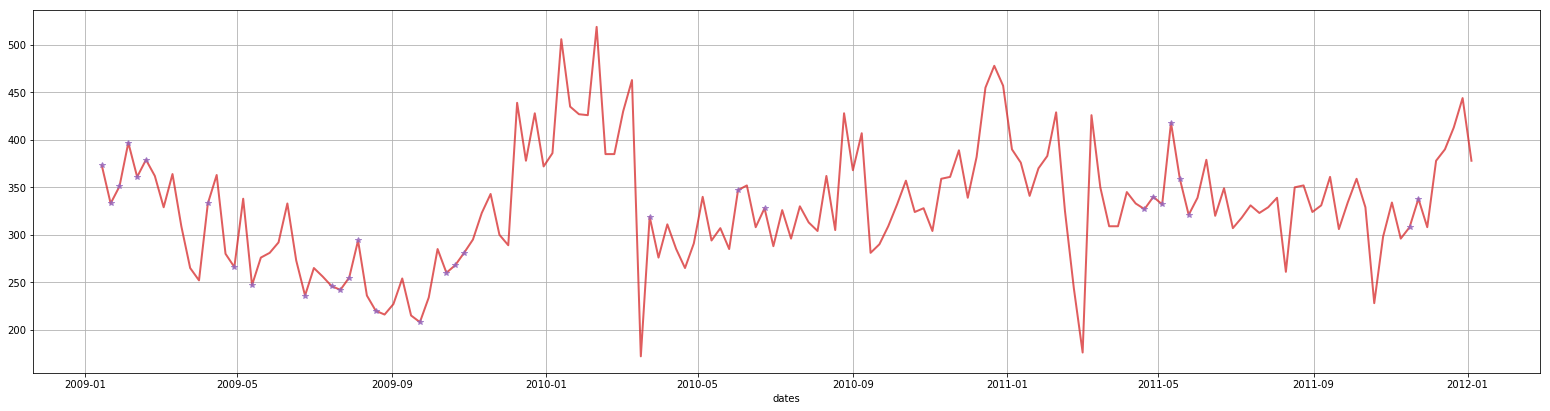

In [13]:
store_name = 'OH_28909_MAINSTREAM_1'
filename = os.path.join(foldername, f'{store_name}.pickle')
df_A = fhelp.readPickleFile(filename)
df_A.head(3)


promo_vars = [iVar for iVar in df_A.columns.tolist() if 'promotion_flag-' in iVar]
sku_promos = df_A[promo_vars].sum(axis=0)

df_A['simultaneous_promos'] = df_A[promo_vars].sum(axis=1)

idx_promos = df_A['simultaneous_promos'] > 4

x_axis, y_data = df_A.date, df_A.total_units

def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Plot one store
f, ax = plt.subplots(1,1,figsize=(fig_w*1.5, fig_h/1.5))
ax.plot(x_axis, y_data, color=def_colours[3], linewidth=2, alpha=0.75)

ax.plot(x_axis[idx_promos], y_data[idx_promos], '*', color=def_colours[4], linewidth=2, alpha=0.75)
#plt.legend()
plt.xlabel('dates')
plt.grid(True)
plt.show()

In [14]:
df_A.head(3)

,date,weekdays,sales-PRETZELS_1111009477-OH_28909_MAINSTREAM_1,promotion_flag-PRETZELS_1111009477-OH_28909_MAINSTREAM_1,sales-PRETZELS_1111009497-OH_28909_MAINSTREAM_1,promotion_flag-PRETZELS_1111009497-OH_28909_MAINSTREAM_1,sales-PRETZELS_1111009507-OH_28909_MAINSTREAM_1,promotion_flag-PRETZELS_1111009507-OH_28909_MAINSTREAM_1,sales-PRETZELS_2840002333-OH_28909_MAINSTREAM_1,promotion_flag-PRETZELS_2840002333-OH_28909_MAINSTREAM_1,...,sales-PRETZELS_7110410471-OH_28909_MAINSTREAM_1,promotion_flag-PRETZELS_7110410471-OH_28909_MAINSTREAM_1,sales-PRETZELS_7797502248-OH_28909_MAINSTREAM_1,promotion_flag-PRETZELS_7797502248-OH_28909_MAINSTREAM_1,sales-PRETZELS_7797508004-OH_28909_MAINSTREAM_1,promotion_flag-PRETZELS_7797508004-OH_28909_MAINSTREAM_1,sales-PRETZELS_7797508006-OH_28909_MAINSTREAM_1,promotion_flag-PRETZELS_7797508006-OH_28909_MAINSTREAM_1,total_units,simultaneous_promos
0,2009-01-14,Wednesday,98,False,123,False,30,False,5,False,...,5.0,True,4,False,24.0,True,7.0,True,373.0,7
1,2009-01-21,Wednesday,85,False,103,False,24,False,9,False,...,7.0,True,9,False,31.0,True,8.0,True,333.0,8
2,2009-01-28,Wednesday,94,False,85,False,21,False,15,True,...,3.0,True,4,False,22.0,True,15.0,False,351.0,10


/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.8/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.8/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


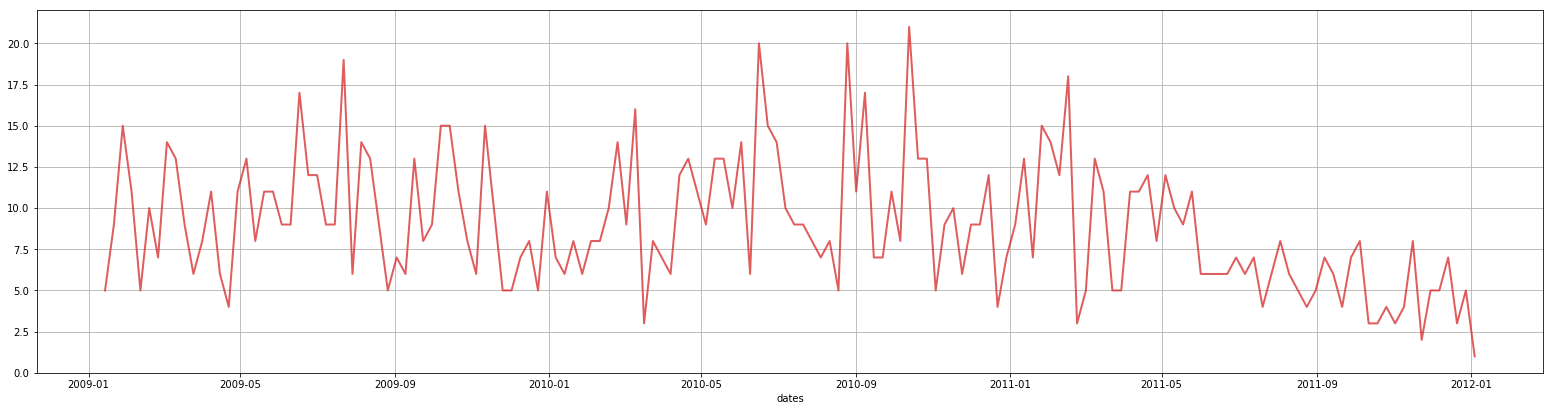

In [15]:
sku_A = 'sales-PRETZELS_2840002333-OH_28909_MAINSTREAM_1'
fhelp.simple_XY_plot(df_A.date, df_A[sku_A])

In [16]:
df_LOESS = fhelp.decompose_signal(df_A[sku_A], period_in_days=2, minimum_heartbeat=0.85)
df_LOESS['date'] = df_A.date
df_LOESS[sku_A] = df_A[sku_A]
df_LOESS.head()

,heartbeat_flag,trend,seasonal,residual,date,sales-PRETZELS_2840002333-OH_28909_MAINSTREAM_1
0,True,5.996950,-0.996950,0.0,2009-01-14,5
1,True,8.059344,0.940656,0.0,2009-01-21,9
2,True,15.883176,-0.883176,0.0,2009-01-28,15
3,True,10.175021,0.824979,0.0,2009-02-04,11
4,True,5.765520,-0.765520,0.0,2009-02-11,5


In [17]:
df_A.head()

promo_vars = [iVar for iVar in df_A.columns.tolist() if 'promotion_flag-' in iVar]
sku_promos = df_A[promo_vars].sum(axis=0)

simultaneous_promos = df_A[promo_vars].sum(axis=1)

simultaneous_promos[0:1]

0    7
dtype: int64

In [18]:
promo_vars[0:2]

['promotion_flag-PRETZELS_1111009477-OH_28909_MAINSTREAM_1',
 'promotion_flag-PRETZELS_1111009497-OH_28909_MAINSTREAM_1']